## Capstone Project: K Nearest Neighbors (kNN) Modelling

In this notebook, using the ratings for four attributes of the beers (aroma, appearance, palate and taste), we train a regression model to predict the overall rating for a beer.

We develop a regression model to identify the correlation between the attributes (collectively as well as individually) and the overall rating for a beer

Author: Uldis Knox

Date: December 11th, 2022

## Table of Contents

1. [K Nearest Neighbors](#http://localhost:8888/notebooks/Desktop/Capstone/Capstone%20KNN.ipynb#KNN) <br>
2. [kNN with Standard Scaler](#http://localhost:8888/notebooks/Desktop/Capstone/Capstone%20KNN.ipynb#Standard-Scaler) <br>
3.  [kNN with MinMax Scaler](#http://localhost:8888/notebooks/Desktop/Capstone/Capstone%20KNN.ipynb#MinMax-Scaler) <br>
4. [Hyperparameter Tuning](#http://localhost:8888/notebooks/Desktop/Capstone/Capstone%20KNN.ipynb#Hyperparameter-Tuning) <br>


----

## kNN Regression Models Introduction

In this notebook will be accomplish the following tasks:

- Isolate features (X) and targets(y). 
- Features are the attributes of the beers (aroma, appearance, palate and taste) and target is overall reviews
- Split dats into train and test sets
- Apply different scalers to compare the fits
- Tune hyperparameters to determine our best fit

documentation of plot-metric here, used for roc_auc graphs https://plot-metric.readthedocs.io/en/latest/    
#pip install plot-metric

## Imports

In [25]:
#import our packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load our dataframe that we cleaned, merged and exported from our EDA notebook.
df_beer = pd.read_csv('data/capstone.csv')
df_beer.head()

,brewery_name,city,country,beer_beerid,beer_name,beer_style,taste,beer_abv,review_overall,review_aroma,review_appearance,review_palate,review_taste,review_profilename
0,Vecchio Birraio,Campo San Martino PD,Italy,47986,Sausa Weizen,Hefeweizen,sweet and fruity with notes of banana and clov...,5.0,1.5,2.0,2.5,1.5,1.5,stcules
1,Vecchio Birraio,Campo San Martino PD,Italy,48213,Red Moon,English Strong Ale,"Malty-sweet with fruity esters, often with a c...",6.2,3.0,2.5,3.0,3.0,3.0,stcules
2,Vecchio Birraio,Campo San Martino PD,Italy,48215,Black Horse Black Beer,Foreign / Export Stout,"roasted grain and malt flavor with a coffee, c...",6.5,3.0,2.5,3.0,3.0,3.0,stcules
3,Vecchio Birraio,Campo San Martino PD,Italy,47969,Sausa Pils,German Pilsener,"bitter taste, malty sweetness, floral hop aroma",5.0,3.0,3.0,3.5,2.5,3.0,stcules
4,Caldera Brewing Company,"Ashland, OR",USA,64883,Cauldron DIPA,American Double / Imperial IPA,"floral, citrus, stone fruit, spicy, pine/resin...",7.7,4.0,4.5,4.0,4.0,4.5,johnmichaelsen


For KNN, we need to have only numeric values in our data set, so we are going to use our numeric ratings columns for this, dropping the rest.

In [3]:
#drop non-numeric columns and numeric columns that aren't needed for this test.
df_beer.drop(['brewery_name', 'city', 'country', 'beer_beerid', 'beer_name', 'beer_style', 'taste', 'beer_abv', 'review_profilename'], axis=1, inplace=True)


In [4]:
#check our refined dataset with only our dependent and independent variables remaining. 
df_beer.head()

,review_overall,review_aroma,review_appearance,review_palate,review_taste
0,1.5,2.0,2.5,1.5,1.5
1,3.0,2.5,3.0,3.0,3.0
2,3.0,2.5,3.0,3.0,3.0
3,3.0,3.0,3.5,2.5,3.0
4,4.0,4.5,4.0,4.0,4.5


Our target feature "review_overall" is currently continuous as it contains a range of values for 1-5, we will remedy this by setting a threshold for the values were a rating of three point five (3.5) or higher equals one (1) and anything below this threshold is zero (0).

In [5]:
#Classify overall review equal to or higher than 4.
df_beer['review_overall'] = np.where( df_beer.review_overall >= 3.5, 1, 0) 

In [6]:
#check our dataframe to see that 'review_overall' has been changed to categorical.
df_beer.head()

,review_overall,review_aroma,review_appearance,review_palate,review_taste
0,0,2.0,2.5,1.5,1.5
1,0,2.5,3.0,3.0,3.0
2,0,2.5,3.0,3.0,3.0
3,0,3.0,3.5,2.5,3.0
4,1,4.5,4.0,4.0,4.5


In [7]:
#export our pared down dataframe to use for our logistic regression model notebook.

df_beer.to_csv('logreg.csv', index=False)

We now have our dataframe pared down to only our numeric rating/review features. From here we will run a KNN model on our data as it exists to see our accuracy, if we need to improve, we will do some hyper parameter optimization. After this we will fit the data with two (2) KNN models using different scalers on each model 1. Standard Scaler and 2. MinMax Scaler and check the performance of each one with Accuracy score and Roc Auc score. We will them run a grid search to tune our hyperparameters which will help determine what our optimal model is.

---

## KNN

In [8]:
#Create KNN model
knn = KNeighborsClassifier()
#Create x and y variables.
X = df_beer.drop(columns=['review_overall'])
y = df_beer['review_overall']
#Split data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
#Training the model.
knn.fit(X_train, y_train)
#Predict test data set.
y_pred = knn.predict(X_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71     85750
           1       0.93      0.95      0.94    389772

    accuracy                           0.90    475522
   macro avg       0.84      0.81      0.83    475522
weighted avg       0.90      0.90      0.90    475522



The classification report is about key metrics in a classification problem.

You'll have precision, recall, f1-score and support for each class you're trying to find.

The recall means "how many of this class you find over the whole number of element of this class"

The precision will be "how many are correctly classified among that class"

The f1-score is the harmonic mean between precision & recall

The support is the number of occurence of the given class in your dataset

The classification report output above shows we have pretty consistent precision and recall for class 1 (beers with an overall rating above 3.5) but a larger difference, 9%, between our precision and recall for class 0 (beers with an overall rating below 3.5) and an accuracy of 90%. Important to note is how imbalanced our data is, we see under "support" that we have 85,750 occurences for class 0 and 389,876 occurences for class 1, to address this, as notd before, we will scale our data as well as perform a grid search to tune hyperparameters to see if we can improve upon our initial model.

We will check our train and test accuracies for this model a few cells below.

roc_auc_score: 0.8147011769368406


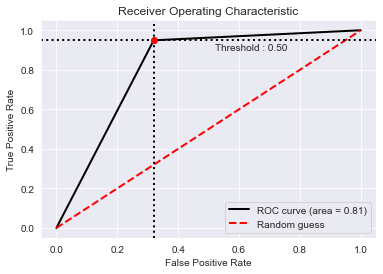

In [9]:
#Checking performance our model with ROC Score and graph
bc = BinaryClassification(y_test, y_pred, labels=["True Negative", "True Positive"])
# Figures
bc.plot_roc_curve()

print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance.

While not truly a curve in this instance, more resembling an obtuse triangle, we can see that we get our maximimum true positive rate, around 97% (0.97), when our false positive rate is around 38% (~0.38).

In [10]:
#Checking our train and test accuracy
print(f'Train Accuracy: {knn.score(X_train,y_train)}')
print(f'Test Accuracy: {knn.score(X_test,y_test)}')

Train Accuracy: 0.9007877067279527
Test Accuracy: 0.900582938328826


Nearly identical performance on the training set and test set is a good outcome, it means the model is doing what it's supposed to do.

Now that was have run a kNN model on our review data, let's see if we can improve the performance with scalers and hyperparameter tuning.

---

## Standard Scaler

In [11]:

#Create copy of dataset.
df_model1 = df_beer.copy()
#Rescaling features 'review_aroma', 'review_appearance','review_palate', 'review_taste'.
Sscaler = StandardScaler()
features = ['review_aroma', 'review_appearance', 'review_palate', 'review_taste']
for feature in features:
    df_model1[feature] = Sscaler.fit_transform(df_model1[[feature]])
#Create KNN Object
knn1 = KNeighborsClassifier()
#Create x and y variable
X1 = df_model1.drop(columns=['review_overall'])
y1 = df_model1['review_overall']
#Split data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=4)
#Training the model
knn1.fit(X1_train, y1_train)
#Predict testing set
y1_pred = knn1.predict(X1_test)
#Checking performance our model with classification report.
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70     85750
           1       0.93      0.94      0.94    389876

    accuracy                           0.90    475626
   macro avg       0.83      0.81      0.82    475626
weighted avg       0.89      0.90      0.89    475626



Our classification report above shows that our precision for class 0 dropped by 2% and the recall for class 0 went up by 2%. Our Class 1 precision remained the same while Class 1 recall dropped 1%, accuracy remained at 90%.

Not really any significant changes after using a Standard Scaler on our data.

roc_auc_score: 0.8111168697817563


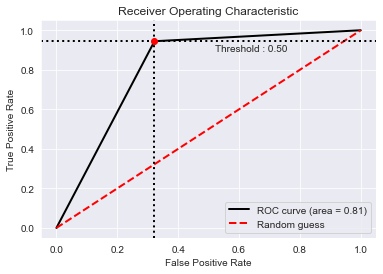

In [12]:
#Checking performance our model with ROC Score and graph
bc = BinaryClassification(y1_test, y1_pred, labels=["True Negative", "True Positive"])
# Figures
bc.plot_roc_curve()

print(f'roc_auc_score: {roc_auc_score(y1_test, y1_pred)}')

The roc_auc_score and plot above is maintaining the same overall shape with the roc_auc_score holding steady at 81%.

In [13]:
#Checking our train and test accuracy
print(f'Train Accuracy: {knn1.score(X1_train,y1_train)}')
print(f'Test Accuracy: {knn1.score(X1_test,y1_test)}')

Train Accuracy: 0.897543147647221
Test Accuracy: 0.8963429249031802


Both our train and test accuracies have decreased slightly after using a Standard Scaler on our data.

---

## MinMax Scaler

In [14]:
#Create copy of dataset.
df_model2 = df_beer.copy()
#Rescaling features 'review_aroma', 'review_appearance','review_palate', 'review_taste'.
MMscaler = MinMaxScaler()
features = [['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]
for feature in features:
    df_model2[feature] = MMscaler.fit_transform(df_model2[feature])
#Create KNN Object
knn2 = KNeighborsClassifier()
#Create x and y variable
X2 = df_model2.drop(columns=['review_overall'])
y2 = df_model2['review_overall']
#Split data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=4)
#Training the model
knn2.fit(X2_train, y2_train)
#Predict testing set
y2_pred = knn2.predict(X2_test)
#Checking performance our model with classification report.
print(classification_report(y2_test, y2_pred))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70     85750
           1       0.93      0.95      0.94    389876

    accuracy                           0.90    475626
   macro avg       0.83      0.81      0.82    475626
weighted avg       0.89      0.90      0.90    475626

roc_auc_score: 0.80711107659647
Train Accuracy: 0.8989298914933762
Test Accuracy: 0.8975308330494969


Accuracy is stable at 90% and we see only slight movements in our precision and recall scores for both classes after using a MinMax Scaler on our data.

roc_auc_score: 0.80711107659647


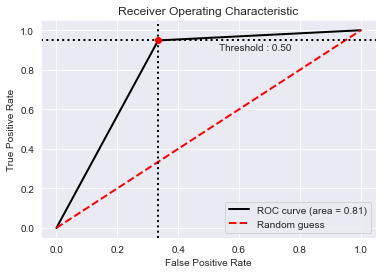

In [15]:
#Checking performance our model with ROC Score and graph
bc = BinaryClassification(y2_test, y2_pred, labels=["True Negative", "True Positive"])
# Figures
bc.plot_roc_curve()

print(f'roc_auc_score: {roc_auc_score(y2_test, y2_pred)}')

No change with our roc_auc_score our plot after MinMax Scaling our data.

In [16]:
#Checking our train and test accuracy
print(f'Train Accuracy: {knn2.score(X2_train,y2_train)}')
print(f'Test Accuracy: {knn2.score(X2_test,y2_test)}')

Train Accuracy: 0.8989298914933762
Test Accuracy: 0.8975308330494969


Incremental improvement in our train and test accuracies, from what we shown with our Standard Scaler and what is shown with our MinMax Scaler.

Overall, we see a drop in train accuracy from our initial kNN model to both models applying scalers. We also saw no change in accuracy, and very small movements, (postive and negative) for our precision and recall scores for both classes. 

Now we will look at hyperparameter tuning to find our best overall fit.

---

## Hyperparameter Tuning

Text(0, 0.5, 'Cross-Validated Accuracy')

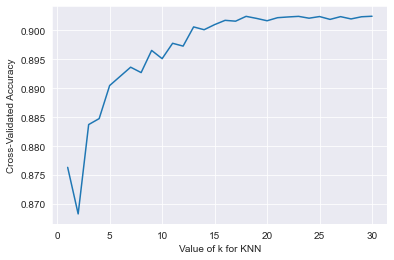

In [19]:
# search for an optimal value of k for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
   knn = KNeighborsClassifier(n_neighbors=k)
   scores = cross_val_score(knn, X, y, cv=3, scoring='accuracy')
   k_scores.append(scores.mean())
# plot the value of k for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

The output above shows that our optimal k value looks to be either 18 or 30, there could be a very small percentage difference between the two k-values. We will next perform hyperparameter tuning to see what the output is for our optimal k-value.

The best values for k code cell took approximately four (4) hours to run.

In [20]:
#List Hyperparameters to tune
grid_params = { 'n_neighbors' :list(range(1,31)),
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
#create our grid
#used verbose=20 to see how long each fit will take with our dataframe
grid = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 20, cv=3, n_jobs = -1)
# fitting the model for grid search
grid_search=grid.fit(X, y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV 2/3; 2/180] START metric=minkowski, n_neighbors=1, weights=distance.........
[CV 2/3; 2/180] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.839 total time= 2.3min
[CV 3/3; 4/180] START metric=minkowski, n_neighbors=2, weights=distance.........
[CV 3/3; 4/180] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.839 total time= 2.2min
[CV 1/3; 8/180] START metric=minkowski, n_neighbors=4, weights=distance.........
[CV 1/3; 8/180] END metric=minkowski, n_neighbors=4, weights=distance;, score=0.897 total time= 2.2min
[CV 1/3; 11/180] START metric=minkowski, n_neighbors=6, weights=uniform.........
[CV 1/3; 11/180] END metric=minkowski, n_neighbors=6, weights=uniform;, score=0.901 total time= 2.2min
[CV 2/3; 14/180] START metric=minkowski, n_neighbors=7, weights=distance........
[CV 2/3; 14/180] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.900 total time= 2.5min
[CV 1/3; 2/180] 

[CV 1/3; 1/180] START metric=minkowski, n_neighbors=1, weights=uniform..........
[CV 1/3; 1/180] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.889 total time= 2.4min
[CV 3/3; 6/180] START metric=minkowski, n_neighbors=3, weights=distance.........
[CV 3/3; 6/180] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.895 total time= 2.2min
[CV 3/3; 8/180] START metric=minkowski, n_neighbors=4, weights=distance.........
[CV 3/3; 8/180] END metric=minkowski, n_neighbors=4, weights=distance;, score=0.893 total time= 2.2min
[CV 1/3; 12/180] START metric=minkowski, n_neighbors=6, weights=distance........
[CV 1/3; 12/180] END metric=minkowski, n_neighbors=6, weights=distance;, score=0.901 total time= 2.2min
[CV 3/3; 14/180] START metric=minkowski, n_neighbors=7, weights=distance........
[CV 3/3; 14/180] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.902 total time= 2.2min
[CV 3/3; 17/180] START metric=minkowski, n_neighbors=9, weights=uniform........

[CV 2/3; 24/180] START metric=minkowski, n_neighbors=12, weights=distance.......
[CV 2/3; 24/180] END metric=minkowski, n_neighbors=12, weights=distance;, score=0.905 total time= 2.3min
[CV 3/3; 27/180] START metric=minkowski, n_neighbors=14, weights=uniform........
[CV 3/3; 27/180] END metric=minkowski, n_neighbors=14, weights=uniform;, score=0.906 total time= 2.4min
[CV 1/3; 31/180] START metric=minkowski, n_neighbors=16, weights=uniform........
[CV 1/3; 31/180] END metric=minkowski, n_neighbors=16, weights=uniform;, score=0.904 total time= 2.5min
[CV 2/3; 34/180] START metric=minkowski, n_neighbors=17, weights=distance.......
[CV 2/3; 34/180] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.907 total time= 2.3min
[CV 3/3; 37/180] START metric=minkowski, n_neighbors=19, weights=uniform........
[CV 3/3; 37/180] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.907 total time= 2.4min
[CV 3/3; 34/180] START metric=minkowski, n_neighbors=17, weights=distance

[CV 2/3; 53/180] START metric=minkowski, n_neighbors=27, weights=uniform........
[CV 2/3; 53/180] END metric=minkowski, n_neighbors=27, weights=uniform;, score=0.908 total time= 2.7min
[CV 2/3; 57/180] START metric=minkowski, n_neighbors=29, weights=uniform........
[CV 2/3; 57/180] END metric=minkowski, n_neighbors=29, weights=uniform;, score=0.908 total time= 2.6min
[CV 3/3; 60/180] START metric=minkowski, n_neighbors=30, weights=distance.......
[CV 3/3; 60/180] END metric=minkowski, n_neighbors=30, weights=distance;, score=0.908 total time= 2.2min
[CV 3/3; 45/180] START metric=minkowski, n_neighbors=23, weights=uniform........
[CV 3/3; 45/180] END metric=minkowski, n_neighbors=23, weights=uniform;, score=0.908 total time= 2.4min
[CV 1/3; 49/180] START metric=minkowski, n_neighbors=25, weights=uniform........
[CV 1/3; 49/180] END metric=minkowski, n_neighbors=25, weights=uniform;, score=0.908 total time= 2.7min
[CV 2/3; 52/180] START metric=minkowski, n_neighbors=26, weights=distance.

[CV 2/3; 55/180] START metric=minkowski, n_neighbors=28, weights=uniform........
[CV 2/3; 55/180] END metric=minkowski, n_neighbors=28, weights=uniform;, score=0.908 total time= 2.6min
[CV 1/3; 59/180] START metric=minkowski, n_neighbors=30, weights=uniform........
[CV 1/3; 59/180] END metric=minkowski, n_neighbors=30, weights=uniform;, score=0.908 total time= 2.5min
[CV 2/3; 62/180] START metric=euclidean, n_neighbors=1, weights=distance........
[CV 2/3; 62/180] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.839 total time= 2.2min
[CV 3/3; 65/180] START metric=euclidean, n_neighbors=3, weights=uniform.........
[CV 3/3; 65/180] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.895 total time= 2.3min
[CV 2/3; 69/180] START metric=euclidean, n_neighbors=5, weights=uniform.........
[CV 2/3; 69/180] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.899 total time= 2.4min
[CV 3/3; 72/180] START metric=euclidean, n_neighbors=6, weights=distance.....

[CV 3/3; 40/180] START metric=minkowski, n_neighbors=20, weights=distance.......
[CV 3/3; 40/180] END metric=minkowski, n_neighbors=20, weights=distance;, score=0.908 total time= 2.3min
[CV 2/3; 43/180] START metric=minkowski, n_neighbors=22, weights=uniform........
[CV 2/3; 43/180] END metric=minkowski, n_neighbors=22, weights=uniform;, score=0.907 total time= 2.3min
[CV 3/3; 46/180] START metric=minkowski, n_neighbors=23, weights=distance.......
[CV 3/3; 46/180] END metric=minkowski, n_neighbors=23, weights=distance;, score=0.908 total time= 2.3min
[CV 3/3; 49/180] START metric=minkowski, n_neighbors=25, weights=uniform........
[CV 3/3; 49/180] END metric=minkowski, n_neighbors=25, weights=uniform;, score=0.908 total time= 2.4min
[CV 1/3; 53/180] START metric=minkowski, n_neighbors=27, weights=uniform........
[CV 1/3; 53/180] END metric=minkowski, n_neighbors=27, weights=uniform;, score=0.907 total time= 2.6min
[CV 1/3; 57/180] START metric=minkowski, n_neighbors=29, weights=uniform.

KNeighborsClassifier(n_neighbors=30)

[CV 1/3; 112/180] START metric=euclidean, n_neighbors=26, weights=distance......
[CV 1/3; 112/180] END metric=euclidean, n_neighbors=26, weights=distance;, score=0.907 total time= 2.4min
[CV 2/3; 115/180] START metric=euclidean, n_neighbors=28, weights=uniform.......
[CV 2/3; 115/180] END metric=euclidean, n_neighbors=28, weights=uniform;, score=0.908 total time= 2.4min
[CV 3/3; 118/180] START metric=euclidean, n_neighbors=29, weights=distance......
[CV 3/3; 118/180] END metric=euclidean, n_neighbors=29, weights=distance;, score=0.907 total time= 2.3min
[CV 1/3; 122/180] START metric=manhattan, n_neighbors=1, weights=distance.......
[CV 1/3; 122/180] END metric=manhattan, n_neighbors=1, weights=distance;, score=0.889 total time= 3.2min
[CV 1/3; 125/180] START metric=manhattan, n_neighbors=3, weights=uniform........
[CV 1/3; 125/180] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.895 total time= 3.3min
[CV 2/3; 128/180] START metric=manhattan, n_neighbors=4, weights=dist

[CV 1/3; 106/180] START metric=euclidean, n_neighbors=23, weights=distance......
[CV 1/3; 106/180] END metric=euclidean, n_neighbors=23, weights=distance;, score=0.907 total time= 2.6min
[CV 2/3; 109/180] START metric=euclidean, n_neighbors=25, weights=uniform.......
[CV 2/3; 109/180] END metric=euclidean, n_neighbors=25, weights=uniform;, score=0.907 total time= 2.4min
[CV 3/3; 112/180] START metric=euclidean, n_neighbors=26, weights=distance......
[CV 3/3; 112/180] END metric=euclidean, n_neighbors=26, weights=distance;, score=0.907 total time= 2.3min
[CV 1/3; 116/180] START metric=euclidean, n_neighbors=28, weights=distance......
[CV 1/3; 116/180] END metric=euclidean, n_neighbors=28, weights=distance;, score=0.907 total time= 2.3min
[CV 1/3; 119/180] START metric=euclidean, n_neighbors=30, weights=uniform.......
[CV 1/3; 119/180] END metric=euclidean, n_neighbors=30, weights=uniform;, score=0.908 total time= 2.5min
[CV 2/3; 122/180] START metric=manhattan, n_neighbors=1, weights=di

[CV 1/3; 114/180] START metric=euclidean, n_neighbors=27, weights=distance......
[CV 1/3; 114/180] END metric=euclidean, n_neighbors=27, weights=distance;, score=0.907 total time= 2.7min
[CV 3/3; 117/180] START metric=euclidean, n_neighbors=29, weights=uniform.......
[CV 3/3; 117/180] END metric=euclidean, n_neighbors=29, weights=uniform;, score=0.907 total time= 2.4min
[CV 1/3; 121/180] START metric=manhattan, n_neighbors=1, weights=uniform........
[CV 1/3; 121/180] END metric=manhattan, n_neighbors=1, weights=uniform;, score=0.889 total time= 4.3min
[CV 2/3; 125/180] START metric=manhattan, n_neighbors=3, weights=uniform........
[CV 2/3; 125/180] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.894 total time= 3.7min
[CV 2/3; 129/180] START metric=manhattan, n_neighbors=5, weights=uniform........
[CV 2/3; 129/180] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.899 total time= 3.3min
[CV 1/3; 133/180] START metric=manhattan, n_neighbors=7, weights=uniform

[CV 3/3; 54/180] START metric=minkowski, n_neighbors=27, weights=distance.......
[CV 3/3; 54/180] END metric=minkowski, n_neighbors=27, weights=distance;, score=0.907 total time= 2.3min
[CV 3/3; 57/180] START metric=minkowski, n_neighbors=29, weights=uniform........
[CV 3/3; 57/180] END metric=minkowski, n_neighbors=29, weights=uniform;, score=0.907 total time= 2.4min
[CV 2/3; 61/180] START metric=euclidean, n_neighbors=1, weights=uniform.........
[CV 2/3; 61/180] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.839 total time= 2.9min
[CV 1/3; 65/180] START metric=euclidean, n_neighbors=3, weights=uniform.........
[CV 1/3; 65/180] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.895 total time= 2.7min
[CV 2/3; 68/180] START metric=euclidean, n_neighbors=4, weights=distance........
[CV 2/3; 68/180] END metric=euclidean, n_neighbors=4, weights=distance;, score=0.892 total time= 2.4min
[CV 1/3; 72/180] START metric=euclidean, n_neighbors=6, weights=distance....

Our Hyperparameter tuning is complete. We chose to include "verbose=20" to see the runtimes for each of our fits to know how long it would take. We can see from the output that it takes as low as 2.2 minutes (still a long run time!!) and as long as 4.3 minutes (2.1 minutes more than our lowest run time!) for each fit to process.

In [24]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)



0.9079540886751962
{'metric': 'minkowski', 'n_neighbors': 30, 'weights': 'uniform'}


**Minkowski Distance** – It is a metric intended for real-valued vector spaces. We can calculate Minkowski distance only in a normed vector space, which means in a space where distances can be represented as a vector that has a length and the lengths cannot be negative.                                                
**n_neighbors** - Number of neighbors to use by default for kneighbors queries.                             
**uniform -** uniform weights. All points in each neighborhood are weighted equally.

Our output above shows that our best accuraacy is 90.79% with the metric of minkowski, n_neighbours of 30 (which is our maximum number of neighbors used, and as we noted after the best value for k, 18 neighbors and 30 neighbors were very close in Cross-Validation Accuracy) and our weights are "uniform". These are our optimal parameters for our kNN model from the parameters we established for the tests.

We we setup an new kNN model with these parameters, create the same outputs as our original test and compare our results.

In [14]:
#Create KNN model with our hyperparameter results
knnhp = KNeighborsClassifier(n_neighbors=30, metric='minkowski', weights='uniform')
#Create x and y variables.
Xhp = df_beer.drop(columns=['review_overall'])
yhp = df_beer['review_overall']
#Split data into training and testing.
Xhp_train, Xhp_test, yhp_train, yhp_test = train_test_split(Xhp, yhp, test_size=0.3, random_state=4)
#Training the model.
knnhp.fit(Xhp_train, yhp_train)
#Predict test data set.
yhp_pred = knn.predict(Xhp_test)
#Checking performance our model with classification report.
print(classification_report(yhp_test, yhp_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71     85750
           1       0.93      0.95      0.94    389772

    accuracy                           0.90    475522
   macro avg       0.84      0.81      0.83    475522
weighted avg       0.90      0.90      0.90    475522



roc_auc_score: 0.8147011769368406


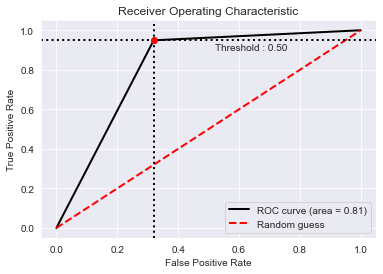

In [15]:
#Checking performance our model with ROC Score and graph
bc = BinaryClassification(yhp_test, yhp_pred, labels=["True Negative", "True Positive"])
# Figures
bc.plot_roc_curve()

print(f'roc_auc_score: {roc_auc_score(yhp_test, yhp_pred)}')

In [16]:
#Checking our train and test accuracy
print(f'Train Accuracy: {knnhp.score(Xhp_train,yhp_train)}')
print(f'Test Accuracy: {knnhp.score(Xhp_test,yhp_test)}')

Train Accuracy: 0.9054490559235726
Test Accuracy: 0.9055143610600561


The results from our optimal parameter kNN model are nearly identical to our original kNN model that we ran earlier. We will compare classification reports below to check.

In [27]:
#comparing our original kNN model with our optimal parameters
print(classification_report(y_test, y_pred))
print(classification_report(yhp_test, yhp_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71     85750
           1       0.93      0.95      0.94    389772

    accuracy                           0.90    475522
   macro avg       0.84      0.81      0.83    475522
weighted avg       0.90      0.90      0.90    475522

              precision    recall  f1-score   support

           0       0.75      0.68      0.71     85750
           1       0.93      0.95      0.94    389772

    accuracy                           0.90    475522
   macro avg       0.84      0.81      0.83    475522
weighted avg       0.90      0.90      0.90    475522



Our classification reports are identical. Tuning our hyper parameters did not improve our model at all.

**Conclusion:** In this notebook we have imported our cleaned dataframe, reduced our features to our numerical rating categories and converted the 'review_overall' (our target) to be categorical. From there we applied a kNN model to our data, followed by two different scalers as our data is left skewed and imbalanced. We saw minor differences between our kNN model and our scaled kNN models. Finally we found our optimal value for k, and also performed some hyperparameter tuning on our data. Our results showed that our original kNN model held identical values as our kNN model using the optimal parameters.


Since we were only modeling based on our numerical rating data, 4 features and 1 target, although we had a lot of data points, we did not have a lot of features. If there is an opportunity to find the same dataset that has the User reviews column still intact, or a different dataset of similar size that includes User reviews so we can label encode and tf-idf the reviews into numerical data, I would hope to see a much wider variance in the data between train and test, and that we could include those reviews in all aspects of the project from EDA, modeling and with the recommender system. For now, this is what we have to work with and the results speak for themselves.

---